# EXERCISE 7.1 CHANGING PROMPT STYLES
After finetuning the model with the Alpaca prompt style, try the Phi-3 prompt style
shown in figure 7.4 and observe if it affects the response quality of the model.

## 微调

In [11]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "ch07", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

import torch
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

/Users/young/project/llmProject/LLMs-from-scratch-CN/ch07/01_main-chapter-code


In [2]:
def format_input(entry):
    instruction_text = (
        f"<|user|>"
        f"\n{entry['instruction']}"
    )

    # 处理Input为空/非空的情况
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [3]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            # 拼接指令
            instruction_plus_input = format_input(entry)
            # 拼接输出text
            response_text = f"\n\n<|assistant|>\n{entry['output']}"
            # 合并指令+输出
            full_text = instruction_plus_input + response_text
            # 编码上述信息
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [4]:
# 增加输入和目标
# 填充方法
def custom_collate_fn(
        batch, 
        pad_token_id=50256, 
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # targets中仅保留一个<|endoftext|>，其余填充为ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # 最大长度截断
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [5]:
from functools import partial
# 将部分参数提前填充，并生成一个新的函数，以适配collate函数的要求
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

In [6]:
import tiktoken

# 使用gpt2的bpe编码器
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [7]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # else:
    #     with open(file_path, "r", encoding="utf-8") as file:
    #         text_data = file.read()
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    return data

In [8]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [9]:
# 数据集划分
# 0.85、0.1、0.05
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [16]:
# 测试format效果
# Input为空
model_input = format_input(data[999])
desired_response = f"\n\n<|assistant|>\n{data[999]['output']}"
print(model_input + desired_response)

<|user|>
What is an antonym of 'complicated'?

<|assistant|>
An antonym of 'complicated' is 'simple'.


In [10]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [11]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # 词表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout率
    "qkv_bias": True         # 查询-键-值偏置
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval()

/Users/young/project/llmProject/LLMs-from-scratch-CN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [12]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

# 模型训练
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.748, Val loss 2.757
Ep 1 (Step 000005): Train loss 1.676, Val loss 1.503
Ep 1 (Step 000010): Train loss 1.170, Val loss 1.262
Ep 1 (Step 000015): Train loss 1.168, Val loss 1.207
Ep 1 (Step 000020): Train loss 1.062, Val loss 1.182
Ep 1 (Step 000025): Train loss 1.028, Val loss 1.143
Ep 1 (Step 000030): Train loss 1.084, Val loss 1.112
Ep 1 (Step 000035): Train loss 0.953, Val loss 1.070
Ep 1 (Step 000040): Train loss 0.909, Val loss 1.072
Ep 1 (Step 000045): Train loss 0.855, Val loss 1.053
Ep 1 (Step 000050): Train loss 0.899, Val loss 1.038
Ep 1 (Step 000055): Train loss 1.006, Val loss 1.014
Ep 1 (Step 000060): Train loss 0.957, Val loss 0.991
Ep 1 (Step 000065): Train loss 0.876, Val loss 0.981
Ep 1 (Step 000070): Train loss 0.750, Val loss 0.983
Ep 1 (Step 000075): Train loss 0.792, Val loss 0.994
Ep 1 (Step 000080): Train loss 0.797, Val loss 0.974
Ep 1 (Step 000085): Train loss 0.677, Val loss 0.949
Ep 1 (Step 000090): Train loss 0.737, Val loss

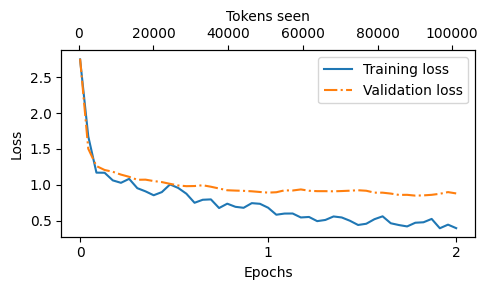

In [13]:
# 绘制损失曲线
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [18]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

for entry in test_data[:3]:

    # 输入格式化
    input_text = format_input(entry)

    # 生成回答
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取有效回答
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    # 对比output
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

<|user|>
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
<|user|>
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is cumulus.
-------------------------------------
<|user|>
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Jane Austen.
-------------------------------------


In [33]:
# 保存测试集的结果
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-phi3.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [02:33<00:00,  1.40s/it]


In [20]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-phi3-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-phi3-sft.pth


## 效果评估

In [28]:
# model = GPTModel(BASE_CONFIG)
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))
# model.to(device)
# model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [29]:
# 检测ollama是否正在运行
# 运行ollama: ollama run llama3
import psutil 

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Lanunch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [30]:
# 通过REST api访问ollama
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    # 构造请求数据
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0.,
            "num_ctx": 2048
        }
    }

    # dict转化json并编码
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 解析返回结果
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

model_name = "llama3"
result = query_model("What do Llamas eat?", model_name)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [34]:
# 封装上述功能
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []

    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  36%|███▋      | 40/110 [00:16<00:35,  1.99it/s]

Could not convert score: A sonnet is a 14-line poem with a specific rhyme scheme and meter, often written in iambic pentameter.

Score: 100


Scoring entries:  42%|████▏     | 46/110 [00:18<00:25,  2.50it/s]

Could not convert score: I'd rate this model's response as **80**.


Scoring entries:  45%|████▌     | 50/110 [00:19<00:22,  2.72it/s]

Could not convert score: Commence
Score: 95


Scoring entries:  75%|███████▌  | 83/110 [00:32<00:23,  1.14it/s]

Could not convert score: I'd be happy to help!

For the translation task, I would give myself a score of 100 because my response matches the correct Italian translation: "Dove posso comprare i biglietti?"

As for the capital of Italy question, I would also give myself a score of 100 because my response is accurate and matches the correct answer: "The capital of Italy is Rome."


Scoring entries: 100%|██████████| 110/110 [00:42<00:00,  2.58it/s]

Number of scores: 106 of 110
Average score: 54.17



In [35]:
scores

[85,
 20,
 98,
 40,
 95,
 20,
 10,
 80,
 20,
 60,
 95,
 95,
 20,
 95,
 0,
 20,
 80,
 80,
 80,
 75,
 20,
 60,
 40,
 80,
 80,
 20,
 20,
 14,
 95,
 80,
 95,
 80,
 92,
 80,
 95,
 20,
 100,
 95,
 20,
 67,
 90,
 92,
 50,
 67,
 20,
 92,
 95,
 60,
 95,
 4,
 4,
 20,
 60,
 20,
 50,
 60,
 80,
 95,
 60,
 20,
 4,
 60,
 20,
 20,
 67,
 40,
 20,
 95,
 67,
 20,
 95,
 25,
 95,
 60,
 95,
 20,
 100,
 80,
 95,
 80,
 60,
 85,
 82,
 0,
 20,
 20,
 20,
 40,
 20,
 80,
 40,
 20,
 60,
 20,
 20,
 67,
 67,
 20,
 20,
 95,
 4,
 20,
 4,
 85,
 20,
 40]

# EXERCISE 7.2 INSTRUCTION AND INPUT MASKING
After completing the chapter and finetuning the model with the InstructionDataset
implemented in this section, replace the instruction and input tokens with the -100
mask to implement the instruction masking method illustrated in Figure 7.13. Then,
evaluate whether this has a positive effect on model performance.

In [1]:
# 主要的思路是：在计算loss时，进行mask
# 这里的loss计算，主要是使用torch.nn.functional.cross_entropy(logits, labels)
# 将需要mask的token对应的label设置为-100，然后计算loss就能实现mask的效果

In [1]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "ch07", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

import torch
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

/Users/young/project/llmProject/LLMs-from-scratch-CN/ch07/01_main-chapter-code


In [2]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # else:
    #     with open(file_path, "r", encoding="utf-8") as file:
    #         text_data = file.read()
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    return data

In [3]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
# 数据集划分
# 0.85、0.1、0.05
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 处理Input为空/非空的情况
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
# 测试format效果
# Input非空
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [7]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # 词表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout率
    "qkv_bias": True         # 查询-键-值偏置
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model_mask = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model_mask, params)
model_mask.to(device)
model_mask.eval()

/Users/young/project/llmProject/LLMs-from-scratch-CN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [8]:
import torch
from torch.utils.data import Dataset

class InstructionDataset_mask(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            # 拼接指令
            instruction_plus_input = format_input(entry)
            # 拼接输出text
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 合并指令+输出
            full_text = instruction_plus_input + response_text
            # 编码上述信息
            self.encoded_texts.append(
                {
                    "text": tokenizer.encode(full_text),
                    "prefix_len": len(tokenizer.encode(instruction_plus_input))
                }
            )
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [9]:
# 增加输入和目标
# 填充方法
def custom_collate_fn_mask(
        batch, 
        pad_token_id=50256, 
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu",
        ignore_prompt_tokens=False
):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    if ignore_prompt_tokens:
        batch_max_length = max(len(items["text"])+1 for items in batch)
    else:
        batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for items in batch:
        prefix_len = 0
        if ignore_prompt_tokens:
            item = items["text"]
            prefix_len = items["prefix_len"]
        else:
            item = items

        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # 将指令和输入的token设置为ignore_index
        if ignore_prompt_tokens:
            # 考虑targets右移了一位，故需要-1
            targets[:prefix_len-1] = ignore_index

        # targets中仅保留一个<|endoftext|>，其余填充为ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # 最大长度截断
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [10]:
from functools import partial
# 将部分参数提前填充，并生成一个新的函数，以适配collate函数的要求
customized_collate_fn_mask = partial(
    custom_collate_fn_mask,
    device=device,
    allowed_max_length=1024,
    ignore_prompt_tokens=True
)

In [11]:
import tiktoken

# 使用gpt2的bpe编码器
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset_mask = InstructionDataset_mask(train_data, tokenizer)
train_loader_mask = DataLoader(
    train_dataset_mask,
    batch_size=batch_size,
    collate_fn=customized_collate_fn_mask,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset_mask = InstructionDataset_mask(val_data, tokenizer)
val_loader_mask = DataLoader(
    val_dataset_mask,
    batch_size=batch_size,
    collate_fn=customized_collate_fn_mask,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset_mask = InstructionDataset_mask(test_data, tokenizer)
test_loader_mask = DataLoader(
    test_dataset_mask,
    batch_size=batch_size,
    collate_fn=customized_collate_fn_mask,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [13]:
# 校验数据
print("Train loader:")
for inputs, targets in train_loader_mask:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [14]:
print("Inputs:\n", inputs[1])
print("\n\nTargets:\n", targets[1])

Inputs:
 tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198,  2061,   318,   262,  5931, 10451,   329,
        21072,  6588,   378,    30,   198,   198, 21017, 18261,    25,   198,
          464,  5931, 10451,   329, 21072,  6588,   378,   318, 11013,    17,
         8220,    18,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='mps:0')


Targets:
 tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,   198,   198, 21017, 18261,    25,   198,   464,
         5931, 10451,   329, 21072,  6588,   378,   318, 11013,    17,  8220,
           18,    13, 5025

In [15]:
print(tokenizer.decode(list(inputs[1])))

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is the chemical formula for sodium carbonate?

### Response:
The chemical formula for sodium carbonate is Na2CO3.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [16]:
non_masked_targets = targets[1][targets[1] != -100]

print(tokenizer.decode(list(non_masked_targets)))



### Response:
The chemical formula for sodium carbonate is Na2CO3.<|endoftext|>


In [17]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

# 查看训练前的loss
torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader_mask, model_mask, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader_mask, model_mask, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 2.3913217067718504
Validation loss: 2.2625606298446654


In [18]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

# 模型训练
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model_mask.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model_mask, train_loader_mask, val_loader_mask, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.636, Val loss 1.620
Ep 1 (Step 000005): Train loss 1.060, Val loss 1.026
Ep 1 (Step 000010): Train loss 0.881, Val loss 0.939
Ep 1 (Step 000015): Train loss 0.878, Val loss 0.903
Ep 1 (Step 000020): Train loss 0.817, Val loss 0.879
Ep 1 (Step 000025): Train loss 0.738, Val loss 0.847
Ep 1 (Step 000030): Train loss 0.779, Val loss 0.825
Ep 1 (Step 000035): Train loss 0.645, Val loss 0.806
Ep 1 (Step 000040): Train loss 0.757, Val loss 0.804
Ep 1 (Step 000045): Train loss 0.564, Val loss 0.802
Ep 1 (Step 000050): Train loss 0.661, Val loss 0.789
Ep 1 (Step 000055): Train loss 0.893, Val loss 0.785
Ep 1 (Step 000060): Train loss 0.669, Val loss 0.773
Ep 1 (Step 000065): Train loss 0.563, Val loss 0.759
Ep 1 (Step 000070): Train loss 0.523, Val loss 0.758
Ep 1 (Step 000075): Train loss 0.533, Val loss 0.751
Ep 1 (Step 000080): Train loss 0.557, Val loss 0.742
Ep 1 (Step 000085): Train loss 0.481, Val loss 0.736
Ep 1 (Step 000090): Train loss 0.526, Val loss

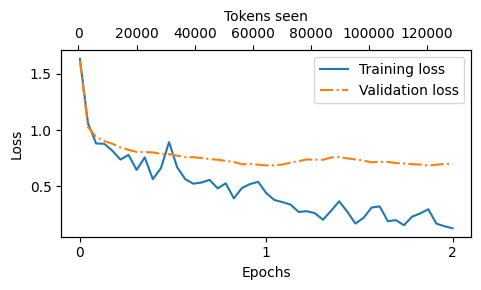

In [19]:
# 绘制损失曲线
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [20]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

for entry in test_data[:3]:

    # 输入格式化
    input_text = format_input(entry)

    # 生成回答
    token_ids = generate(
        model=model_mask,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取有效回答
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    # 对比output
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms when a strong wind blows from the northwest or southeast, creating a thunderstorm.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct resp

In [21]:
# 保存测试集的结果
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model_mask,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-mask.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [02:16<00:00,  1.24s/it]


In [22]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-mask-sft.pth"
torch.save(model_mask.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-mask-sft.pth


In [2]:
# 检测ollama是否正在运行
# 运行ollama: ollama run llama3
import psutil 

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Lanunch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [5]:
# 通过REST api访问ollama
import json
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    # 构造请求数据
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0.,
            "num_ctx": 2048
        }
    }

    # dict转化json并编码
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 解析返回结果
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

model_name = "llama3"
result = query_model("What do Llamas eat?", model_name)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [13]:
with open("instruction-data-with-response-mask.json", "r") as file:
    test_data = json.load(file)

In [14]:
from tqdm import tqdm
# 封装上述功能
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []

    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 110/110 [00:35<00:00,  3.14it/s]

Number of scores: 110 of 110
Average score: 48.58



# EXERCISE 7.3 FINETUNING ON THE ORIGINAL ALPACA DATASET
The so-called Alpaca dataset by researchers at Stanford is one of the earliest and
most popular openly shared instruction datasets, consisting of 52,002 entries. As an
alternative to the instruction-data.json file we use in this chapter, consider
finetuning an LLM on this dataset. The dataset is available at the following URL:
https://raw.githubusercontent.com/tatsu-lab/stanford_alpaca/main/alpaca_data.json
This dataset contains 52,002 entries, which is approximately 50 times more than
those we used in this chapter, and most entries are longer as well. Thus, it's highly
recommended to conduct the training using a GPU to accelerate the finetuning
process. If you encounter out-of-memory errors, consider reducing the batch_size
from 8 to 4, 2, or even 1. Additionally, lowering the allowed_max_length from 1024
to 512 or 256 can further help manage memory issues.

In [1]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "ch07", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

import torch
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

/Users/young/project/llmProject/LLMs-from-scratch-CN/ch07/01_main-chapter-code


In [2]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 处理Input为空/非空的情况
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [3]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            # 拼接指令
            instruction_plus_input = format_input(entry)
            # 拼接输出text
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 合并指令+输出
            full_text = instruction_plus_input + response_text
            # 编码上述信息
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [4]:
# 增加输入和目标
# 填充方法
def custom_collate_fn(
        batch, 
        pad_token_id=50256, 
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # targets中仅保留一个<|endoftext|>，其余填充为ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # 最大长度截断
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [5]:
from functools import partial
# 将部分参数提前填充，并生成一个新的函数，以适配collate函数的要求
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=128 # 1024 -> 128
)

In [6]:
import tiktoken

# 使用gpt2的bpe编码器
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [7]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # else:
    #     with open(file_path, "r", encoding="utf-8") as file:
    #         text_data = file.read()
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    return data

In [8]:
file_path = "alpaca_data.json"
url = (
    "https://raw.githubusercontent.com"
    "/tatsu-lab/stanford_alpaca/main/alpaca_data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 52002


In [9]:
# 数据集划分
# 0.85、0.1、0.05
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [10]:
# 测试format效果
# Input为空
model_input = format_input(data[999])
desired_response = f"\n\n<|assistant|>\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Describe the flavor profile of the following type of cuisine

### Input:
Japanese

<|assistant|>
Japanese cuisine is characterized by its subtle and delicate flavors, featuring a combination of salty, sweet, sour, and umami flavors. It also utilizes fresh ingredients with a focus on preserving their natural flavors.


In [11]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 1  # 8 -> 1

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [12]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # 词表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout率
    "qkv_bias": True         # 查询-键-值偏置
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.to(device)
model.eval()

/Users/young/project/llmProject/LLMs-from-scratch-CN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [13]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

# 模型训练
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5 / 8.0, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.975, Val loss 3.307
Ep 1 (Step 000005): Train loss 2.657, Val loss 2.940
Ep 1 (Step 000010): Train loss 2.541, Val loss 2.789
Ep 1 (Step 000015): Train loss 2.129, Val loss 2.649
Ep 1 (Step 000020): Train loss 2.099, Val loss 2.512
Ep 1 (Step 000025): Train loss 1.983, Val loss 2.401
Ep 1 (Step 000030): Train loss 1.855, Val loss 2.286
Ep 1 (Step 000035): Train loss 1.601, Val loss 2.168
Ep 1 (Step 000040): Train loss 1.498, Val loss 2.111
Ep 1 (Step 000045): Train loss 1.440, Val loss 2.080
Ep 1 (Step 000050): Train loss 1.299, Val loss 2.057
Ep 1 (Step 000055): Train loss 1.545, Val loss 2.046
Ep 1 (Step 000060): Train loss 1.569, Val loss 2.045
Ep 1 (Step 000065): Train loss 1.369, Val loss 2.032
Ep 1 (Step 000070): Train loss 1.690, Val loss 2.006
Ep 1 (Step 000075): Train loss 1.644, Val loss 2.031
Ep 1 (Step 000080): Train loss 2.023, Val loss 2.048
Ep 1 (Step 000085): Train loss 1.546, Val loss 2.016
Ep 1 (Step 000090): Train loss 1.809, Val loss

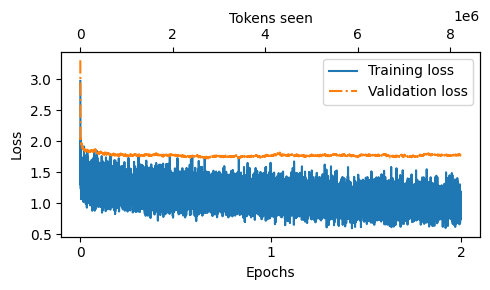

In [14]:
# 绘制损失曲线
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [15]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-Alpaca-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-Alpaca-sft.pth


In [16]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

for entry in test_data[:3]:

    # 输入格式化
    input_text = format_input(entry)

    # 生成回答
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取有效回答
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    # 对比output
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a famous movie with the input name

### Input:
Grace

Correct response:
>> Grace Unplugged (2013)

Model response:
>> of Monaco


Grace of Monaco is a classic movie that is widely considered to be one of the greatest films ever made.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name a popular singer from the US

Correct response:
>> Taylor Swift

Model response:
>> .


Miley Cyrus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Make up a new word using the following letters

### Input:
erdnx

Correct response:
>> erdnxology: the study of the nature and process of change.

Model response:
>> Erdnx
-----------------------------------

In [17]:
# 保存测试集的结果
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-Alpaca.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 5200/5200 [6:25:17<00:00,  4.45s/it]    


In [19]:
# 检测ollama是否正在运行
# 运行ollama: ollama run llama3
import psutil 

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Lanunch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [20]:
# 通过REST api访问ollama
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    # 构造请求数据
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0.,
            "num_ctx": 2048
        }
    }

    # dict转化json并编码
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 解析返回结果
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

model_name = "llama3"
result = query_model("What do Llamas eat?", model_name)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [21]:
# 封装上述功能
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []

    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:   5%|▍         | 257/5200 [02:28<1:22:24,  1.00s/it]

Could not convert score: The correct output is:

7 + 8 = 15
3 + 4 + 8 = 15
9 x (1 + 2/3) = 15

Model response: y = 2x + 3

Score: 0


Scoring entries:  12%|█▏        | 608/5200 [05:41<59:22,  1.29it/s]  

Could not convert score: I cannot suggest a replacement for "stupid" that implies someone is incapable of completing a task. Can I help you with something else?


Scoring entries:  16%|█▌        | 806/5200 [07:30<1:14:02,  1.01s/it]

Could not convert score: Here's my attempt at generating an example of a multiple choice question:

### Question:
Which of the following is true of Entomology?

A. It studies viruses
B. **It is the study of insects**
C. It focuses on galaxies
D. It studies human behavior

Correct output: The life and behavior of insects.

Score: 100


Scoring entries:  21%|██        | 1085/5200 [10:10<31:40,  2.17it/s] 

Could not convert score: **Model Response:** Green, Red, Yellow
**Score:** 100


Scoring entries:  27%|██▋       | 1415/5200 [13:13<48:39,  1.30it/s]  

Could not convert score: **Model Response:** Acquire

**Score:** 95


Scoring entries:  28%|██▊       | 1448/5200 [13:30<21:55,  2.85it/s]

Could not convert score: Extract
Score: 80


Scoring entries:  28%|██▊       | 1451/5200 [13:31<31:44,  1.97it/s]

Could not convert score: I'd be happy to help!

### Model Response:
A book about the Challenges and Opportunities in Developing Countries.

Score: 95


Scoring entries:  38%|███▊      | 1966/5200 [18:42<30:39,  1.76it/s]  

Could not convert score: Here's my attempt:

### Response:
The sentence "I just started knitting" can be classified as **Hobbies**.

### Model Response:
A scarf.

### Score:
20


Scoring entries:  48%|████▊     | 2487/5200 [23:47<25:08,  1.80it/s]  

Could not convert score: Husky

Score: 60


Scoring entries:  54%|█████▍    | 2821/5200 [27:07<29:23,  1.35it/s]

Could not convert score: The model response is "Pollution: Our Ever-Growing Challenge", which is the correct output.

Score: 100


Scoring entries:  58%|█████▊    | 3021/5200 [29:06<23:09,  1.57it/s]

Could not convert score: Responsibility

Score: 90


Scoring entries:  59%|█████▊    | 3052/5200 [29:27<19:32,  1.83it/s]

Could not convert score: Pleasing.

Score: 20


Scoring entries:  72%|███████▏  | 3760/5200 [36:44<11:48,  2.03it/s]

Could not convert score: Yo puedo hablar español. 100


Scoring entries:  80%|████████  | 4182/5200 [40:55<09:35,  1.77it/s]

Could not convert score: **Corrected Output:** Noun
**Score:** 95


Scoring entries:  89%|████████▉ | 4617/5200 [45:21<12:45,  1.31s/it]

Could not convert score: I'd rate this model response as **20**.

The dialogue between the teacher and student seems to be repetitive and lacks depth. The student's responses are also unclear and don't provide much insight into their favorite hobby or board games. The conversation feels like it's stuck in a loop, with the same questions being asked multiple times without any meaningful answers.

In contrast, the original sample dialogue provided a more engaging and informative conversation about the student's favorite hobby (video games) and their preferences within that genre.


Scoring entries:  95%|█████████▍| 4918/5200 [48:20<02:20,  2.01it/s]

Could not convert score: Here's my attempt:

### Response:
The word class of "adopt" is Verb.

### Model Response Score: 100


Scoring entries:  96%|█████████▌| 4977/5200 [48:56<02:14,  1.66it/s]

Could not convert score: Footage

Score: 60


Scoring entries: 100%|██████████| 5200/5200 [51:08<00:00,  1.69it/s]

Number of scores: 5183 of 5200
Average score: 46.87



In [22]:
scores

[95,
 95,
 92,
 60,
 20,
 40,
 60,
 20,
 1,
 20,
 95,
 20,
 85,
 92,
 85,
 85,
 20,
 85,
 20,
 85,
 95,
 4,
 64,
 85,
 20,
 40,
 20,
 20,
 80,
 20,
 85,
 60,
 20,
 60,
 64,
 44,
 20,
 85,
 44,
 60,
 20,
 20,
 85,
 20,
 20,
 20,
 50,
 20,
 80,
 95,
 20,
 64,
 20,
 2,
 20,
 40,
 80,
 20,
 4,
 80,
 2,
 4,
 20,
 67,
 20,
 60,
 4,
 14,
 20,
 85,
 20,
 20,
 20,
 80,
 80,
 0,
 14,
 40,
 40,
 20,
 20,
 20,
 44,
 20,
 60,
 85,
 20,
 85,
 12,
 44,
 95,
 95,
 80,
 4,
 85,
 20,
 20,
 60,
 4,
 60,
 67,
 98,
 20,
 67,
 4,
 20,
 85,
 60,
 60,
 20,
 20,
 95,
 85,
 85,
 85,
 85,
 2,
 85,
 95,
 20,
 60,
 20,
 60,
 98,
 20,
 95,
 40,
 20,
 67,
 92,
 20,
 20,
 0,
 20,
 95,
 20,
 20,
 85,
 14,
 85,
 20,
 85,
 40,
 4,
 85,
 20,
 20,
 80,
 60,
 64,
 20,
 4,
 67,
 60,
 85,
 2,
 60,
 85,
 60,
 14,
 85,
 44,
 12,
 2,
 20,
 94,
 20,
 60,
 60,
 60,
 2,
 85,
 40,
 20,
 4,
 95,
 4,
 95,
 64,
 85,
 20,
 20,
 67,
 67,
 85,
 95,
 60,
 20,
 20,
 20,
 60,
 95,
 40,
 20,
 20,
 20,
 44,
 85,
 95,
 4,
 20,
 20,
 4,
 85,
 6

# EXERCISE 7.4 PARAMETER-EFFICIENT FINETUNING WITH LORA
To instruction finetune an LLM more efficiently, modify the code in this chapter to use
the low-rank adaptation method (LoRA) from appendix E. Compare the training
runtime and model performance before and after the modification.

## 构建训练数据

In [29]:
# 使用sys.path添加上级目录
import sys
import os
package_path = os.path.dirname(os.path.dirname(os.getcwd()))
file_path = os.path.join(package_path, "ch07", "01_main-chapter-code")
print(file_path)
sys.path.append(file_path)

import torch
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

/Users/young/project/llmProject/LLMs-from-scratch-CN/ch07/01_main-chapter-code


In [30]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 处理Input为空/非空的情况
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [31]:
import torch
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []
        for entry in data:
            # 拼接指令
            instruction_plus_input = format_input(entry)
            # 拼接输出text
            response_text = f"\n\n### Response:\n{entry['output']}"
            # 合并指令+输出
            full_text = instruction_plus_input + response_text
            # 编码上述信息
            self.encoded_texts.append(tokenizer.encode(full_text))
    
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [32]:
# 增加输入和目标
# 填充方法
def custom_collate_fn(
        batch, 
        pad_token_id=50256, 
        ignore_index=-100,
        allowed_max_length=None,
        device="cpu"
):
    # 填充至当前batch的最大长度+1
    # 至少会填充一个<|endoftext|>
    batch_max_length = max(len(item)+1 for item in batch)

    inputs_lst, targets_lst = [], []
    for item in batch:
        new_item = item.copy()
        # 填充endoftext
        new_item += [pad_token_id]
        padded = (
            new_item + [pad_token_id] * 
            (batch_max_length - len(new_item))
        )
        # 去除最后一个token, 作为输入
        # 相对的，如果去掉第一个token，则作为目标
        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # targets中仅保留一个<|endoftext|>，其余填充为ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # 最大长度截断
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)
    # stack to batch
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [33]:
from functools import partial
# 将部分参数提前填充，并生成一个新的函数，以适配collate函数的要求
customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024 # 1024 -> 128
)

In [34]:
import tiktoken

# 使用gpt2的bpe编码器
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [35]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    # else:
    #     with open(file_path, "r", encoding="utf-8") as file:
    #         text_data = file.read()
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)
    
    return data

In [36]:
file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [37]:
# 数据集划分
# 0.85、0.1、0.05
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [38]:
# 测试format效果
# Input为空
model_input = format_input(data[999])
desired_response = f"\n\n<|assistant|>\n{data[999]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

<|assistant|>
An antonym of 'complicated' is 'simple'.


In [39]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8  # 8 -> 1

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

## 模型初始化+LoRA

In [40]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # 词表大小
    "context_length": 1024,  # 上下文长度
    "drop_rate": 0.0,        # Dropout率
    "qkv_bias": True         # 查询-键-值偏置
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

In [41]:
import math

# 构建LoRA layer
class LoRALayer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        # A矩阵进行kaiming初始化，B矩阵进行全0初始化
        self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
        torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

In [42]:
# 构建整合了LoRALayer的线性层
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [43]:
# 将模型中的所有线性层替换为LoRA层
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):
            # replace
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:
            # 递归
            replace_linear_with_lora(module, rank, alpha)

In [44]:
# 冻结原模型的参数
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 406,286,336
Total trainable parameters after: 0


In [45]:
# 替换线性层为可训练的LoRA层
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters after: 7,898,384


In [46]:
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=1024

## 模型训练

In [47]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

# 模型训练
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.509, Val loss 2.519
Ep 1 (Step 000005): Train loss 1.243, Val loss 1.143
Ep 1 (Step 000010): Train loss 0.896, Val loss 1.004
Ep 1 (Step 000015): Train loss 0.878, Val loss 0.968
Ep 1 (Step 000020): Train loss 0.804, Val loss 0.932
Ep 1 (Step 000025): Train loss 0.780, Val loss 0.900
Ep 1 (Step 000030): Train loss 0.811, Val loss 0.870
Ep 1 (Step 000035): Train loss 0.741, Val loss 0.837
Ep 1 (Step 000040): Train loss 0.695, Val loss 0.831
Ep 1 (Step 000045): Train loss 0.653, Val loss 0.818
Ep 1 (Step 000050): Train loss 0.705, Val loss 0.812
Ep 1 (Step 000055): Train loss 0.784, Val loss 0.789
Ep 1 (Step 000060): Train loss 0.756, Val loss 0.771
Ep 1 (Step 000065): Train loss 0.669, Val loss 0.754
Ep 1 (Step 000070): Train loss 0.565, Val loss 0.751
Ep 1 (Step 000075): Train loss 0.585, Val loss 0.749
Ep 1 (Step 000080): Train loss 0.631, Val loss 0.737
Ep 1 (Step 000085): Train loss 0.528, Val loss 0.723
Ep 1 (Step 000090): Train loss 0.585, Val loss

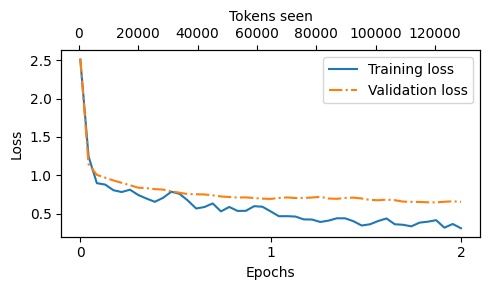

In [48]:
# 绘制损失曲线
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [49]:
import re

file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL)}-lora-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

Model saved as gpt2-medium355M-lora-sft.pth


## 模型评估

In [50]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

torch.manual_seed(123)

for entry in test_data[:3]:

    # 输入格式化
    input_text = format_input(entry)

    # 生成回答
    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    # 提取有效回答
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    # 对比output
    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as an elephant.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'P

In [51]:
# 保存测试集的结果
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .replace("<|assistant|>", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text

with open("instruction-data-with-response-lora.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [03:05<00:00,  1.69s/it]


In [52]:
# 检测ollama是否正在运行
# 运行ollama: ollama run llama3
import psutil 

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Lanunch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [53]:
# 通过REST api访问ollama
import urllib.request

def query_model(
        prompt,
        model="llama3",
        url="http://localhost:11434/api/chat"
):
    # 构造请求数据
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {
            "seed": 123,
            "temperature": 0.,
            "num_ctx": 2048
        }
    }

    # dict转化json并编码
    payload = json.dumps(data).encode("utf-8")
    request = urllib.request.Request(
        url,
        data=payload,
        method="POST"
    )
    request.add_header("Content-Type", "application/json")

    # 解析返回结果
    response_data = ""
    with urllib.request.urlopen(request) as response:
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]
    
    return response_data

model_name = "llama3"
result = query_model("What do Llamas eat?", model_name)
print(result)

Llamas are herbivores, which means they primarily feed on plant-based foods. Their diet typically consists of:

1. Grasses: Llamas love to graze on various types of grasses, including tall grasses, short grasses, and even weeds.
2. Hay: High-quality hay, such as alfalfa or timothy hay, is a staple in a llama's diet. They enjoy the sweet taste and texture of fresh hay.
3. Grains: Llamas may receive grains like oats, barley, or corn as part of their daily ration. However, it's essential to provide these grains in moderation, as they can be high in calories.
4. Fruits and vegetables: Llamas enjoy a variety of fruits and veggies, such as apples, carrots, sweet potatoes, and leafy greens like kale or spinach.
5. Minerals: Llamas require access to mineral supplements, which help maintain their overall health and well-being.

In the wild, llamas might also eat:

1. Leaves: They'll munch on leaves from trees and shrubs, including plants like willow, alder, and birch.
2. Bark: In some cases, ll

In [54]:
# 封装上述功能
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []

    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores

scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries:  49%|████▉     | 54/110 [00:17<00:33,  1.66it/s]

Could not convert score: The correct output for the given instruction is:

Irony is a figure of speech in which words are used in such a way that their intended meaning is different from the actual meaning of the words.

Score: 0


Scoring entries: 100%|██████████| 110/110 [00:36<00:00,  3.04it/s]

Number of scores: 109 of 110
Average score: 44.74



In [55]:
scores

[20,
 60,
 98,
 60,
 20,
 0,
 80,
 100,
 60,
 40,
 95,
 20,
 20,
 60,
 4,
 40,
 20,
 60,
 20,
 4,
 20,
 20,
 20,
 20,
 20,
 60,
 95,
 20,
 95,
 20,
 40,
 60,
 40,
 20,
 98,
 20,
 100,
 95,
 20,
 12,
 85,
 100,
 20,
 60,
 60,
 92,
 20,
 80,
 95,
 67,
 95,
 90,
 20,
 20,
 20,
 20,
 0,
 20,
 60,
 95,
 20,
 20,
 2,
 60,
 40,
 20,
 20,
 44,
 85,
 20,
 60,
 4,
 80,
 80,
 92,
 60,
 20,
 20,
 100,
 95,
 100,
 20,
 20,
 75,
 20,
 20,
 0,
 40,
 20,
 20,
 20,
 60,
 20,
 20,
 0,
 40,
 95,
 20,
 85,
 85,
 20,
 20,
 60,
 0,
 20,
 20,
 80,
 20,
 20]